In [1]:
import numpy as np
import pandas as pd
import pymystem3
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from navec import Navec

nltk.download('stopwords')
navec = Navec.load('Data/navec_hudlit_v1_12B_500K_300d_100q.tar')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maksimkoltugin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Download data

In [2]:
train_df = pd.read_excel('Data/train_data_exam_1.xlsx')
test_df = pd.read_excel('Data/test_data_exam_1.xlsx')

print(train_df.shape)
print(test_df.shape)

(18779, 2)
(8048, 2)


### Delete N/A's and rows containing non-string value at 'original_data'

In [3]:
train_df = train_df.dropna()
train_df = train_df[pd.to_numeric(train_df['original_data'], errors='coerce').isna()].reset_index(drop=True)
test_df = test_df.dropna()
test_df = test_df[pd.to_numeric(test_df['original_data'], errors='coerce').isna()].reset_index(drop=True)

X_train, y_train = train_df['original_data'], train_df['score']
X_test, y_test = test_df['original_data'], test_df['score']

print(X_train.shape)
print(X_test.shape)

(18715,)
(8020,)


### Tokenize, lemmatize data

In [4]:
m = pymystem3.Mystem()


def lemmatize(X):
    data = []
    for s in tqdm(X):
        s = re.sub(r"[\\:,.?“/!@#$1234567890#—_ツ►๑۩۞۩•*”˜˜”*°°*`)(]", ' ', s)
        s = m.lemmatize(s)
        s = ''.join(s)
        data.append(s)
    return data


lem_X_train = lemmatize(X_train)
lem_X_test = lemmatize(X_test)

print(lem_X_train[12345])

100%|██████████| 8020/8020 [00:36<00:00, 219.91it/s]

главное-не терять разговорный русский  иначе быть порицать    с индус общаться вот где хард кор  английский вообще-то из европа    в скандинавия  великобритания неплохо он владеть    ваш ко  недавно находить свой читательский билет  английский библиотека  залогиниться  обнаруживать возможность скачивать неплохий аудиокнига  если говорить о современный российский  то они предпочитать робото зачитывание  а точно весь они в топка    а английский  довольно качественный  сейчас  приключение геккельберифин с нигер слушать      у вы и русский постепенно теряться  по крайний мера  письменный    например  в этот пост слово иностранный  офис  по-русски писаться без двойной  ф    я в переводчик на смартфон говорить по-русски  а он по-английски  в планшет наоборот настраивать  хотеть процент    попадание добиваться 



### Downsample/upsample, so that each label is present in the amount of $n$ observations

In [5]:
train_df = pd.concat([pd.DataFrame(lem_X_train), y_train], axis=1)

print(f"before balancing:\n{train_df['score'].value_counts()}")

strong_negative = train_df[train_df['score'] == -2]
negative = train_df[train_df['score'] == -1]
neutral = train_df[train_df['score'] == 0]
positive = train_df[train_df['score'] == 1]
strong_positive = train_df[train_df['score'] == 2]

n = neutral.shape[0]

params = {'replace': True, 'n_samples': n, 'random_state': 0}

strong_negative = resample(strong_negative, **params)
negative = resample(negative, **params)
neutral = resample(neutral, **params)
positive = resample(positive, **params)
strong_positive = resample(strong_positive, **params)

train_df = pd.concat([strong_negative, negative, neutral, positive, strong_positive])
lem_X_train, y_train = train_df[0].tolist(), train_df['score']

print(f"\nafter balancing:\n{train_df['score'].value_counts()}")

before balancing:
 0    9737
-1    6465
 1    1204
-2    1059
 2     250
Name: score, dtype: int64

after balancing:
-2    9737
-1    9737
 0    9737
 1    9737
 2    9737
Name: score, dtype: int64


### Form the tf-idf matrix (not used for doc2idxs, doc2vec, doc2marix)

In [6]:
words = stopwords.words("russian")
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), stop_words=words, max_df=0.1, min_df=0.002)

X_train_test = tfidf_vectorizer.fit_transform(lem_X_train + lem_X_test).toarray()
tfidf_X_train, tfidf_X_test = X_train_test[:len(lem_X_train), :], X_train_test[len(lem_X_train):, :]

features = tfidf_vectorizer.get_feature_names_out()
print(features[1000:1050])
print(f'\nVocabulary size: {len(features)}')
print(tfidf_X_train.shape, tfidf_X_test.shape)

['дворецкий' 'дворник' 'дворянин' 'де' 'дебил' 'девать' 'деваться'
 'девица' 'девочка' 'девушка' 'девчата' 'девчонка' 'дегенерат' 'дед'
 'дедов' 'дедушка' 'действие' 'действительно' 'действительность'
 'действительный' 'действовать' 'действующий' 'декабрь' 'делаться'
 'делить' 'делиться' 'деловой' 'дельный' 'демографический' 'демократ'
 'демократический' 'демократия' 'демонстрация' 'демонстрировать' 'денежки'
 'денежный' 'денис' 'депозит' 'депутат' 'деревня' 'дерево' 'держава'
 'держать' 'держаться' 'дерьмо' 'десант' 'десятилетие' 'десяток' 'десятый'
 'десять']

Vocabulary size: 5663
(48685, 5663) (8020, 5663)


In [7]:
np.save('Data/balanced/tfidf_X_train', tfidf_X_train)
np.save('Data/balanced/y_train', y_train)
np.save('Data/balanced/tfidf_X_test', tfidf_X_test)
np.save('Data/balanced/y_test', y_test)

### Display distribution of doc lenghtes (to choose max_text_length, which will be used for doc2idxs, doc2matrix):

100%|██████████| 8020/8020 [00:06<00:00, 1279.38it/s]


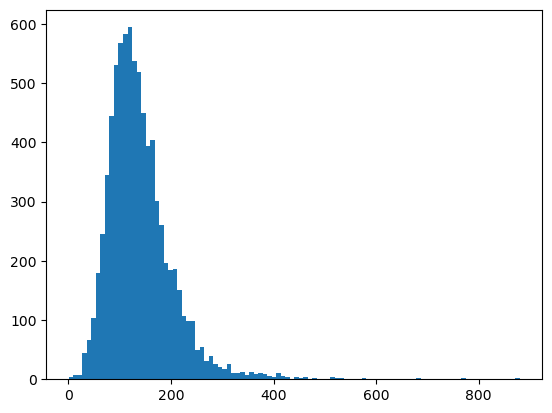

In [8]:
doc_lengthes = []
for doc_idx in tqdm(range(len(lem_X_test))):
    doc_length = 0
    for word in lem_X_test[doc_idx].split(' '):
        try:
            _ = navec[word]
            doc_length += 1
        except KeyError:
            pass
    doc_lengthes.append(doc_length)

plt.hist(doc_lengthes, bins=100)
plt.show()

### Doc2idxs (for self-training embeddings using torch.Embedding)

In [9]:
max_text_length = 200
padding_symbol = 0
vocabulary = {'<padding>': padding_symbol}
curr_idx = 1

print(f'padding_index: {padding_symbol}')


def doc2idxs(list_of_docs: list):
    global curr_idx
    result = []
    for doc_idx in tqdm(range(len(list_of_docs))):
        doc_words = []
        for word in list_of_docs[doc_idx].split(' '):
            try:
                _ = navec[word]
                if word not in vocabulary:
                    vocabulary[word] = curr_idx
                    curr_idx += 1

                doc_words.append(vocabulary[word])
            except KeyError:
                pass
        doc_words = [padding_symbol] * (max_text_length - len(doc_words)) + doc_words
        result.append(doc_words[:max_text_length])
    return np.array(result)


doc2idxs_X_train = doc2idxs(lem_X_train)
doc2idxs_X_test = doc2idxs(lem_X_test)
print(doc2idxs_X_train.shape, doc2idxs_X_test.shape)
print("Vocabulary size:", curr_idx + 1)

padding_index: 0


100%|██████████| 8020/8020 [00:06<00:00, 1195.43it/s]

(48685, 200) (8020, 200)
Vocabulary size: 36879


In [10]:
np.save('Data/balanced/doc2idxs_X_train', doc2idxs_X_train)
np.save('Data/balanced/doc2idxs_X_test', doc2idxs_X_test)

### Doc2matrix

In [11]:
def doc2matrix(list_of_docs: list):
    unk = navec['<unk>']
    pad = navec['<pad>']

    data = []
    for doc_idx in tqdm(range(len(list_of_docs))):
        doc_words = []
        for word in list_of_docs[doc_idx].split(' '):
            if word in vocabulary:
                embedding = navec.get(word, unk)
                doc_words.append(embedding)
        doc_words = [pad] * (max_text_length - len(doc_words)) + doc_words
        doc_embeddings = np.vstack(doc_words[:max_text_length])
        data.append(doc_embeddings)
    data = np.stack(data)
    return data

doc2matrix_X_train = doc2matrix(lem_X_train)
doc2matrix_X_test = doc2matrix(lem_X_test)

print(doc2matrix_X_train.shape)
print(doc2matrix_X_test.shape)

100%|██████████| 8020/8020 [00:10<00:00, 782.46it/s]


(48685, 200, 300)
(8020, 200, 300)


In [12]:
np.save('Data/balanced/doc2matrix_X_train', doc2matrix_X_train)
np.save('Data/balanced/doc2matrix_X_test', doc2matrix_X_test)

### Doc2vec

In [13]:
def doc2vec(list_of_docs: list):
    data = []
    for doc_idx in tqdm(range(len(list_of_docs))):
        doc_words = []
        for word in list_of_docs[doc_idx].split(' '):
            if word in vocabulary:
                embedding = navec.get(word)
                doc_words.append(embedding)
        doc_embeddings = np.vstack(doc_words).sum(axis=0)
        data.append(doc_embeddings)
    data = np.stack(data)
    return data

doc2vec_X_train = doc2vec(lem_X_train)
doc2vec_X_test = doc2vec(lem_X_test)

print(doc2vec_X_train.shape)
print(doc2vec_X_test.shape)

100%|██████████| 8020/8020 [00:08<00:00, 994.50it/s] 


(48685, 300)
(8020, 300)


In [14]:
np.save('Data/balanced/doc2vec_X_train', doc2vec_X_train)
np.save('Data/balanced/doc2vec_X_test', doc2vec_X_test)